# Project 3 : Web APIs & Classification
_____________________________________________________________________________________________________

# Problem Statement

1. Finding the word that is the most likely to use in each subreddit (marvelstudios & DC_Cinematic).
2. Application to use for analysis text or message from chat or Email and classify them ?
3. Examine the performance of various techniques employed for classification.

# Gathering the data from reddit
_____________________________________________________________________________________________________

# Import library

In [483]:
import requests
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

# Import our model!
from sklearn.naive_bayes import MultinomialNB

# Import lemmatizer.
from nltk.stem import WordNetLemmatizer

import regex as re
import nltk

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, confusion_matrix

# For Example to scrape the data from Reddit

In [7]:
url = 'https://www.reddit.com/r/marvelstudios.json'

In [8]:
headers = {'User-agent':'Kanakorn'} ### Create dummy of 'headers'

In [9]:
res = requests.get(url,headers=headers)

In [10]:
res.status_code

200

In [11]:
res.json()

{'kind': 'Listing',
 'data': {'modhash': '',
  'dist': 27,
  'children': [{'kind': 't3',
    'data': {'approved_at_utc': None,
     'subreddit': 'marvelstudios',
     'selftext': 'This thread is for discussion about the ASSEMBLED episode and overall discussion about the WandaVision series.\n\n**This also marks one week since the WandaVision finale. Per the subreddit rules, spoilers no longer need to be tagged for WandaVision in this thread or on the subreddit.**\n\n-\n\n|EPISODE|TITLE|ORIGINAL RELEASE DATE|RUNTIME|\n|:-----------|:------------:|:------------:|:------------:|\n|S1E01|The Making of WandaVision|March 12, 2021 on Disney+|58 min\n\n---\n\nFor a look back on the season, check out the episode discussion threads and easter egg megathread below:\n\n---\n\n* [Episode 1 Discussion Thread](https://www.reddit.com/r/marvelstudios/comments/kxq31v/wandavision_s01e01_discussion_thread/)\n\n* [Episode 2 Discussion Thread](https://www.reddit.com/r/marvelstudios/comments/kxq33b/wandavisio

In [12]:
marvel_json = res.json()

In [13]:
marvel_json.keys()

dict_keys(['kind', 'data'])

In [14]:
marvel_json['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [15]:
marvel_json['data']['children']

[{'kind': 't3',
  'data': {'approved_at_utc': None,
   'subreddit': 'marvelstudios',
   'selftext': 'This thread is for discussion about the ASSEMBLED episode and overall discussion about the WandaVision series.\n\n**This also marks one week since the WandaVision finale. Per the subreddit rules, spoilers no longer need to be tagged for WandaVision in this thread or on the subreddit.**\n\n-\n\n|EPISODE|TITLE|ORIGINAL RELEASE DATE|RUNTIME|\n|:-----------|:------------:|:------------:|:------------:|\n|S1E01|The Making of WandaVision|March 12, 2021 on Disney+|58 min\n\n---\n\nFor a look back on the season, check out the episode discussion threads and easter egg megathread below:\n\n---\n\n* [Episode 1 Discussion Thread](https://www.reddit.com/r/marvelstudios/comments/kxq31v/wandavision_s01e01_discussion_thread/)\n\n* [Episode 2 Discussion Thread](https://www.reddit.com/r/marvelstudios/comments/kxq33b/wandavision_s01e02_discussion_thread/)\n\n* [Episode 3 Discussion Thread](https://www.red

In [16]:
### Check total count of post/ scraping 1 round
### There are approximately 27 posts/ scraping 1 round

len(marvel_json['data']['children'])

27

In [17]:
### Check 'after'

marvel_json['data']['after']

't3_m70i2o'

In [18]:
### Loop for find the list of 'after'

post = [post['data']['name'] for post in marvel_json['data']['children']]
print(f'Number of posts = {len(post)}')
post

Number of posts = 27


['t3_m3dz8u',
 't3_m5k5tj',
 't3_m6us7a',
 't3_m6nmeh',
 't3_m6zgpy',
 't3_m6gltr',
 't3_m6xbz4',
 't3_m68lwx',
 't3_m6taxs',
 't3_m6n7jr',
 't3_m6pxqp',
 't3_m6ej78',
 't3_m6ph6j',
 't3_m6z5dq',
 't3_m70799',
 't3_m6xpoz',
 't3_m6zwzy',
 't3_m6vqp3',
 't3_m6qart',
 't3_m60ils',
 't3_m6iu3a',
 't3_m6z6ya',
 't3_m6ev1v',
 't3_m6pt05',
 't3_m6xuw5',
 't3_m6ko2o',
 't3_m70i2o']

In [494]:
### Testing by assign after == 't3_m70i2o' 
### (for example of after will change everytime when we 'Run' the code)

param = {'after':marvel_json['data']['after']}

In [493]:
### Test by using 'after'
### <Response [200]> == OK

requests.get(url,params=param,headers=headers)

<Response [200]>

# Scraping the data from Reddit (1000 posts)

In [21]:
### Write for loop to scrape post of marvel in reddit 4 rounds (apploximately 25 posts/round)
### Totally ~1000 posts/ subreddit

posts = []
after = None

### url of subreddit
url_all = ['https://www.reddit.com/r/marvelstudios.json','https://www.reddit.com/r/DC_Cinematic.json']

for u in url_all:
    for i in range(40): ## For loop 40 rounds for getting 1000 posts from reddit (25 posts/round)
        print(i)
        if after == None:
            params = {}
        else:
            params = {'after': after}
        
        url = u
        res = requests.get(url,params=params,headers=headers)
    
        if res.status_code == 200: ### Check response
            marvel_json = res.json()
            posts.extend(marvel_json['data']['children']) ### extend post from scraping into 'posts'
            after = marvel_json['data']['after']
        else:
            print(res.status_code)
            break
        
        time.sleep(random.randint(1,5)) ## Getting the data every 1-5 second (random)/ 1 loop

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [22]:
posts[0]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'marvelstudios',
  'selftext': 'This thread is for discussion about the ASSEMBLED episode and overall discussion about the WandaVision series.\n\n**This also marks one week since the WandaVision finale. Per the subreddit rules, spoilers no longer need to be tagged for WandaVision in this thread or on the subreddit.**\n\n-\n\n|EPISODE|TITLE|ORIGINAL RELEASE DATE|RUNTIME|\n|:-----------|:------------:|:------------:|:------------:|\n|S1E01|The Making of WandaVision|March 12, 2021 on Disney+|58 min\n\n---\n\nFor a look back on the season, check out the episode discussion threads and easter egg megathread below:\n\n---\n\n* [Episode 1 Discussion Thread](https://www.reddit.com/r/marvelstudios/comments/kxq31v/wandavision_s01e01_discussion_thread/)\n\n* [Episode 2 Discussion Thread](https://www.reddit.com/r/marvelstudios/comments/kxq33b/wandavision_s01e02_discussion_thread/)\n\n* [Episode 3 Discussion Thread](https://www.reddit.

In [23]:
### Check total posts

len(posts)

1952

## Create the DataFrame to collect all posts from scraping

In [25]:
name = []
title = []
selftext = []
subreddit = []

for i in range(len(posts)):
    name.append(posts[i]['data']['name'])
    title.append(posts[i]['data']['title'])
    selftext.append(posts[i]['data']['selftext'])
    subreddit.append(posts[i]['data']['subreddit'])
    
df = pd.DataFrame({'name':name,'title':title,'selftext':selftext,'subreddit':subreddit})
df

,name,title,selftext,subreddit
0,t3_m3dz8u,ASSEMBLED - The Making of WandaVision - Discus...,This thread is for discussion about the ASSEMB...,marvelstudios
1,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios
2,t3_m6us7a,God Bless this Mess,,marvelstudios
3,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios
4,t3_m6zgpy,The peanut butter Natasha eats in Endgame expi...,,marvelstudios
...,...,...,...,...
1947,t3_lys9m0,OTHER: Updated look at Uxas/Darkseid in Zack S...,,DC_Cinematic
1948,t3_lz8jgx,HUMOR: Snyder Cut Peacemaker exhibit,,DC_Cinematic
1949,t3_lz5wc7,News: We're excited to announce that the Snyde...,,DC_Cinematic
1950,t3_lz71yu,HUMOR: Just heard,,DC_Cinematic


In [26]:
### Check column 'selftext' to find the space value
### So, I will use column 'title' to train model because column 'selftext' has a few of data (about 1237 rows).

df[df['selftext']=='']

,name,title,selftext,subreddit
1,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios
2,t3_m6us7a,God Bless this Mess,,marvelstudios
3,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios
4,t3_m6zgpy,The peanut butter Natasha eats in Endgame expi...,,marvelstudios
5,t3_m6gltr,It has been three years since this epic poster...,,marvelstudios
...,...,...,...,...
1947,t3_lys9m0,OTHER: Updated look at Uxas/Darkseid in Zack S...,,DC_Cinematic
1948,t3_lz8jgx,HUMOR: Snyder Cut Peacemaker exhibit,,DC_Cinematic
1949,t3_lz5wc7,News: We're excited to announce that the Snyde...,,DC_Cinematic
1950,t3_lz71yu,HUMOR: Just heard,,DC_Cinematic


In [27]:
### Check the duplicate post from title
### There are 1872 unique posts

df['title'].nunique()

1872

In [28]:
### Check the duplicate post from title
### There are 80 duplicate posts

df[df.duplicated(['title'])]

,name,title,selftext,subreddit
332,t3_m4djwp,New BTS photos of WandaVision,,marvelstudios
922,t3_m3dz8u,ASSEMBLED - The Making of WandaVision - Discus...,This thread is for discussion about the ASSEMB...,marvelstudios
923,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios
924,t3_m6us7a,God Bless this Mess,,marvelstudios
925,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios
...,...,...,...,...
996,t3_m65nt2,The Falcon and The Scarlet Witch!,,marvelstudios
997,t3_m6qmkr,Anybody know where I can find an HD version of...,,marvelstudios
998,t3_m6ts6z,In No Specific Order!,,marvelstudios
1251,t3_m5h50x,OTHER: This is my Superman.,,DC_Cinematic


In [29]:
### Example for duplicate title

df[df['title']=='New BTS photos of WandaVision']

,name,title,selftext,subreddit
309,t3_m50amv,New BTS photos of WandaVision,,marvelstudios
332,t3_m4djwp,New BTS photos of WandaVision,,marvelstudios


In [30]:
### Remove duplicate post

df = df.drop_duplicates(['title'])
df.reset_index(drop=True,inplace=True)

In [31]:
df.shape

(1872, 4)

In [32]:
### Check subreddit. If equal to 1 == don't have another subreddit from scraping post.
### subreddit == 2 (marvelstudios and DC_Cinematic)

df['subreddit'].nunique()

2

In [245]:
### Number of post from subreddit "marvelstudios"

len(df[df['subreddit']=='marvelstudios'])

921

In [246]:
### Number of post from subreddit "DC_Cinematic"

len(df[df['subreddit']=='DC_Cinematic'])

951

# Cleaning word
_____________________________________________________________________________________________________

Step :
1. Remove Non-Letters such as number or special characters (-.?/"!).
2. Remove Stopwords
3. Lemmatizing

## Remove Non-Letters : 

### Try to test with one text from DataFrame by Regular Expression

In [33]:
### Print the text of title in the first row

test_title_0 = df['title'][0]
test_title_0

'ASSEMBLED - The Making of WandaVision - Discussion Thread'

In [34]:
# Use regular expressions to do a find-and-replace

title_regex = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      test_title_0)          # The text to search

In [35]:
title_regex

'ASSEMBLED   The Making of WandaVision   Discussion Thread'

### Use regular expression with all text in column 'title'

In [36]:
### Use map to modify all text in column 'title' and create new column is 'title_regex'

df['title_regex'] = df['title'].map(lambda x:re.sub("[^a-zA-Z]"," ",x.lower()))

<ipython-input-36-a801a09fc2f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_regex'] = df['title'].map(lambda x:re.sub("[^a-zA-Z]"," ",x.lower()))


In [37]:
df.head()

,name,title,selftext,subreddit,title_regex
0,t3_m3dz8u,ASSEMBLED - The Making of WandaVision - Discus...,This thread is for discussion about the ASSEMB...,marvelstudios,assembled the making of wandavision discus...
1,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios,marvel studios the falcon and the winter sold...
2,t3_m6us7a,God Bless this Mess,,marvelstudios,god bless this mess
3,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios,we have met noobmaster before captain ame...
4,t3_m6zgpy,The peanut butter Natasha eats in Endgame expi...,,marvelstudios,the peanut butter natasha eats in endgame expi...


## Remove Stopwords : 

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
### Import stopwords.

from nltk.corpus import stopwords

In [40]:
### Split text up at each space.

df['title_regex_split'] = df['title_regex'].map(lambda x:x.split())

<ipython-input-40-d95c8d5eaece>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_regex_split'] = df['title_regex'].map(lambda x:x.split())


In [41]:
df.head()

,name,title,selftext,subreddit,title_regex,title_regex_split
0,t3_m3dz8u,ASSEMBLED - The Making of WandaVision - Discus...,This thread is for discussion about the ASSEMB...,marvelstudios,assembled the making of wandavision discus...,"[assembled, the, making, of, wandavision, disc..."
1,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios,marvel studios the falcon and the winter sold...,"[marvel, studios, the, falcon, and, the, winte..."
2,t3_m6us7a,God Bless this Mess,,marvelstudios,god bless this mess,"[god, bless, this, mess]"
3,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios,we have met noobmaster before captain ame...,"[we, have, met, noobmaster, before, captain, a..."
4,t3_m6zgpy,The peanut butter Natasha eats in Endgame expi...,,marvelstudios,the peanut butter natasha eats in endgame expi...,"[the, peanut, butter, natasha, eats, in, endga..."


In [496]:
### Remove subreddit name >> 'marvel', 'dc', 'studios', 'cinematic'

stopwords_default = stopwords.words('english')
print(f'Length of stopwords before add special word : {len(stopwords_default)}')

### Add special words to stop words

stopwords_default.extend(['marvel', 'dc', 'studios', 'cinematic'])
print(f'Length of stopwords after add special word : {len(stopwords_default)}')

Length of stopwords before add special word : 179
Length of stopwords after add special word : 183


In [43]:
# Remove stopwords from text (use column = 'title_regex_split') in each row

df['title_regex_rmstop'] = df['title_regex_split'].map(lambda x:[w for w in x if w not in stopwords_default])

<ipython-input-43-db9b73b98e83>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_regex_rmstop'] = df['title_regex_split'].map(lambda x:[w for w in x if w not in stopwords_default])


In [44]:
df.head()

,name,title,selftext,subreddit,title_regex,title_regex_split,title_regex_rmstop
0,t3_m3dz8u,ASSEMBLED - The Making of WandaVision - Discus...,This thread is for discussion about the ASSEMB...,marvelstudios,assembled the making of wandavision discus...,"[assembled, the, making, of, wandavision, disc...","[assembled, making, wandavision, discussion, t..."
1,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios,marvel studios the falcon and the winter sold...,"[marvel, studios, the, falcon, and, the, winte...","[falcon, winter, soldier, final, trailer, disney]"
2,t3_m6us7a,God Bless this Mess,,marvelstudios,god bless this mess,"[god, bless, this, mess]","[god, bless, mess]"
3,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios,we have met noobmaster before captain ame...,"[we, have, met, noobmaster, before, captain, a...","[met, noobmaster, captain, america, winter, so..."
4,t3_m6zgpy,The peanut butter Natasha eats in Endgame expi...,,marvelstudios,the peanut butter natasha eats in endgame expi...,"[the, peanut, butter, natasha, eats, in, endga...","[peanut, butter, natasha, eats, endgame, expir..."


## Lemmatizing :

In [45]:
lemmatizer = WordNetLemmatizer()

In [46]:
### Lemmatizing is converting words with a list of words in the dictionary.

df['title_regex_lem'] = df['title_regex_rmstop'].map(lambda x:[lemmatizer.lemmatize(w) for w in x])

<ipython-input-46-e7c6b8a32625>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_regex_lem'] = df['title_regex_rmstop'].map(lambda x:[lemmatizer.lemmatize(w) for w in x])


In [497]:
df.head()

,name,title,selftext,subreddit,title_regex,title_regex_split,title_regex_rmstop,title_regex_lem,title_regex_onestring
0,t3_m3dz8u,ASSEMBLED - The Making of WandaVision - Discus...,This thread is for discussion about the ASSEMB...,marvelstudios,assembled the making of wandavision discus...,"[assembled, the, making, of, wandavision, disc...","[assembled, making, wandavision, discussion, t...","[assembled, making, wandavision, discussion, t...",assembled making wandavision discussion thread
1,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios,marvel studios the falcon and the winter sold...,"[marvel, studios, the, falcon, and, the, winte...","[falcon, winter, soldier, final, trailer, disney]","[falcon, winter, soldier, final, trailer, disney]",falcon winter soldier final trailer disney
2,t3_m6us7a,God Bless this Mess,,marvelstudios,god bless this mess,"[god, bless, this, mess]","[god, bless, mess]","[god, bless, mess]",god bless mess
3,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios,we have met noobmaster before captain ame...,"[we, have, met, noobmaster, before, captain, a...","[met, noobmaster, captain, america, winter, so...","[met, noobmaster, captain, america, winter, so...",met noobmaster captain america winter soldier
4,t3_m6zgpy,The peanut butter Natasha eats in Endgame expi...,,marvelstudios,the peanut butter natasha eats in endgame expi...,"[the, peanut, butter, natasha, eats, in, endga...","[peanut, butter, natasha, eats, endgame, expir...","[peanut, butter, natasha, eats, endgame, expir...",peanut butter natasha eats endgame expires may...


## Join the words back into one string : 

In [48]:
### Join the words back into one string separated by space

df['title_regex_onestring'] = df['title_regex_lem'].map(lambda x:" ".join(x))

<ipython-input-48-fc0f818dcd92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_regex_onestring'] = df['title_regex_lem'].map(lambda x:" ".join(x))


In [49]:
df.head()

,name,title,selftext,subreddit,title_regex,title_regex_split,title_regex_rmstop,title_regex_lem,title_regex_onestring
0,t3_m3dz8u,ASSEMBLED - The Making of WandaVision - Discus...,This thread is for discussion about the ASSEMB...,marvelstudios,assembled the making of wandavision discus...,"[assembled, the, making, of, wandavision, disc...","[assembled, making, wandavision, discussion, t...","[assembled, making, wandavision, discussion, t...",assembled making wandavision discussion thread
1,t3_m5k5tj,Marvel Studios' The Falcon and The Winter Sold...,,marvelstudios,marvel studios the falcon and the winter sold...,"[marvel, studios, the, falcon, and, the, winte...","[falcon, winter, soldier, final, trailer, disney]","[falcon, winter, soldier, final, trailer, disney]",falcon winter soldier final trailer disney
2,t3_m6us7a,God Bless this Mess,,marvelstudios,god bless this mess,"[god, bless, this, mess]","[god, bless, mess]","[god, bless, mess]",god bless mess
3,t3_m6nmeh,We have met Noobmaster69 before... Captain Ame...,,marvelstudios,we have met noobmaster before captain ame...,"[we, have, met, noobmaster, before, captain, a...","[met, noobmaster, captain, america, winter, so...","[met, noobmaster, captain, america, winter, so...",met noobmaster captain america winter soldier
4,t3_m6zgpy,The peanut butter Natasha eats in Endgame expi...,,marvelstudios,the peanut butter natasha eats in endgame expi...,"[the, peanut, butter, natasha, eats, in, endga...","[peanut, butter, natasha, eats, endgame, expir...","[peanut, butter, natasha, eats, endgame, expir...",peanut butter natasha eats endgame expires may...


# EDA (Text Analysis)
_____________________________________________________________________________________________________

## Subreddit : marvelstudios

In [218]:
### Combine word from every row in the column 'title_regex_lem'

text_eda_mar = []
for i in df[df['subreddit']=='marvelstudios']['title_regex_lem']:
    text_eda_mar.extend(i)

In [219]:
### Print the total of vocab after lemmatizing = 6214 words

print(f'Number of vocab = {len(text_eda_mar)}')
print(text_eda_mar[:100])

Number of vocab = 6214
['assembled', 'making', 'wandavision', 'discussion', 'thread', 'falcon', 'winter', 'soldier', 'final', 'trailer', 'disney', 'god', 'bless', 'mess', 'met', 'noobmaster', 'captain', 'america', 'winter', 'soldier', 'peanut', 'butter', 'natasha', 'eats', 'endgame', 'expires', 'may', 'endgame', 'meaning', 'helping', 'year', 'old', 'peanut', 'butter', 'thing', 'even', 'sadder', 'imagined', 'natasha', 'post', 'snap', 'world', 'three', 'year', 'since', 'epic', 'poster', 'released', 'avenger', 'infinity', 'war', 'love', 'helmet', 'hud', 'shot', 'made', 'stormbreaker', 'hope', 'guy', 'enjoy', 'captain', 'america', 'first', 'avenger', 'visual', 'reference', 'incredible', 'hulk', 'make', 'sense', 'considering', 'hulk', 'born', 'trying', 'recreate', 'super', 'soldier', 'serum', 'like', 'photoshop', 'old', 'painting', 'scott', 'lang', 'realized', 'tony', 'death', 'endgame', 'mirror', 'yinsen', 'death', 'iron', 'man', 'position', 'sharing', 'one', 'last', 'meaningful', 'exchang

In [220]:
### Count the number of each words of all posts

dic_vocab_mar = {i:text_eda_mar.count(i) for i in text_eda_mar}
print(dic_vocab_mar)

{'assembled': 6, 'making': 7, 'wandavision': 118, 'discussion': 8, 'thread': 5, 'falcon': 74, 'winter': 74, 'soldier': 68, 'final': 7, 'trailer': 12, 'disney': 25, 'god': 5, 'bless': 1, 'mess': 2, 'met': 3, 'noobmaster': 2, 'captain': 36, 'america': 21, 'peanut': 2, 'butter': 2, 'natasha': 4, 'eats': 1, 'endgame': 40, 'expires': 1, 'may': 4, 'meaning': 2, 'helping': 1, 'year': 23, 'old': 12, 'thing': 15, 'even': 10, 'sadder': 1, 'imagined': 1, 'post': 14, 'snap': 5, 'world': 5, 'three': 4, 'since': 2, 'epic': 5, 'poster': 12, 'released': 4, 'avenger': 50, 'infinity': 21, 'war': 30, 'love': 22, 'helmet': 1, 'hud': 1, 'shot': 5, 'made': 31, 'stormbreaker': 1, 'hope': 24, 'guy': 12, 'enjoy': 6, 'first': 24, 'visual': 3, 'reference': 6, 'incredible': 3, 'hulk': 16, 'make': 17, 'sense': 3, 'considering': 1, 'born': 1, 'trying': 1, 'recreate': 1, 'super': 4, 'serum': 1, 'like': 49, 'photoshop': 7, 'painting': 13, 'scott': 2, 'lang': 1, 'realized': 4, 'tony': 17, 'death': 5, 'mirror': 2, 'yin

In [225]:
### Create DataFrame of all vocab (descending sort).

key_mar = []
value_mar = []
for i,j in dic_vocab_mar.items():
    key_mar.append(i)
    value_mar.append(j)

df_vocab_mar = pd.DataFrame(key_mar,columns=['vocab'])
df_vocab_mar['frequency'] = value_mar
print(df_vocab_mar.shape)
df_vocab_mar = df_vocab_mar.sort_values(by='frequency',ascending=False)
df_vocab_mar.set_index('vocab',inplace=True)
df_vocab_mar.head()

(2060, 2)


,frequency
vocab,
mcu,123
wandavision,118
falcon,74
winter,74
soldier,68


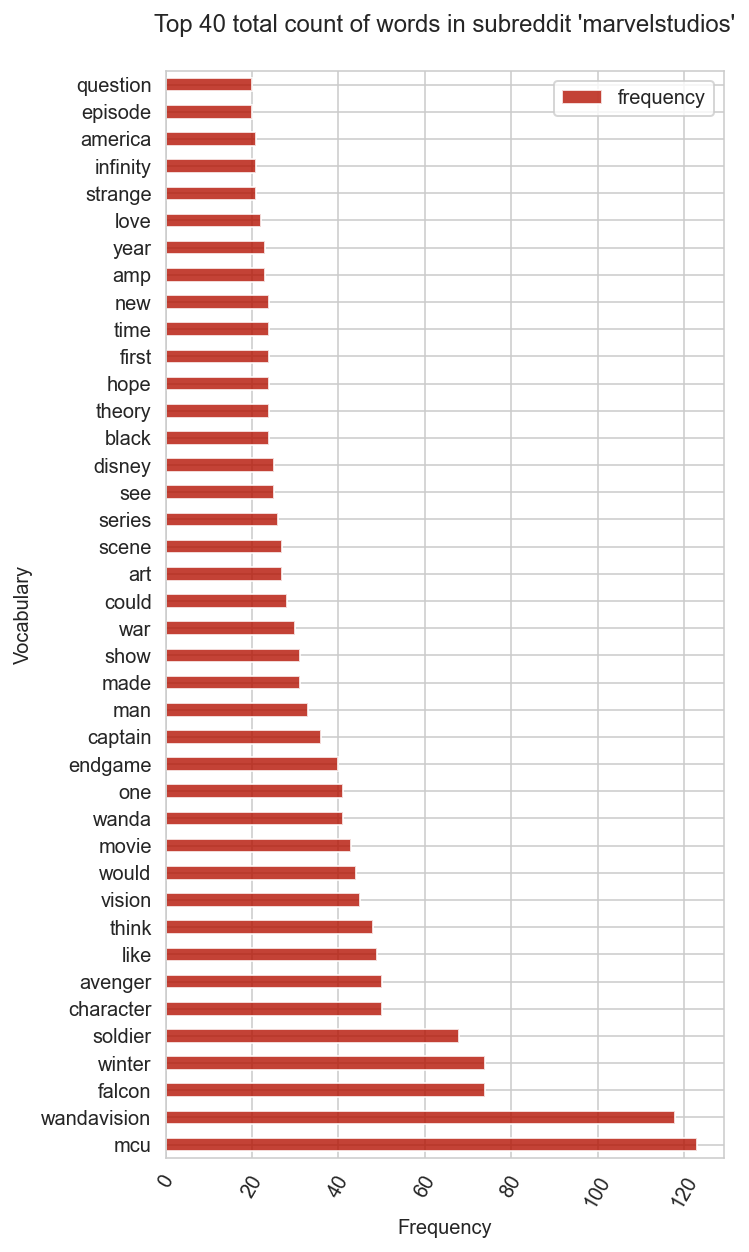

In [274]:
### Plot graph to analyze total number of words (Top40)

df_vocab_mar.head(40).plot(kind='barh',figsize=(5,10),color='#B41303',alpha=0.8);
plt.legend();
plt.title("Top 40 total count of words in subreddit 'marvelstudios'\n",fontsize=12);
plt.xlabel('Frequency')
plt.ylabel('Vocabulary')
plt.xticks(rotation = 60);

## Subreddit : DC_Cinematic

In [240]:
### Combine word from every row in the column 'title_regex_lem'

text_eda_dc = []
for i in df[df['subreddit']=='DC_Cinematic']['title_regex_lem']:
    text_eda_dc.extend(i)

In [241]:
### Print the total of vocab after lemmatizing = 7507 words

print(f'Number of vocab = {len(text_eda_dc)}')
print(text_eda_dc[:100])

Number of vocab = 7507
['r', 'exclusive', 'interview', 'fan', 'q', 'amp', 'director', 'zack', 'snyder', 'zack', 'snyder', 'justice', 'league', 'review', 'megathread', 'post', 'embargo', 'edition', 'review', 'score', 'related', 'discussion', 'belong', 'humour', 'elseworld', 'lex', 'luthor', 'jeremy', 'kirby', 'approves', 'zsjl', 'humor', 'u', 'clock', 'strike', 'midnight', 'moment', 'waited', 'year', 'appreciation', 'remembering', 'jon', 'schnepp', 'one', 'first', 'earliest', 'people', 'defend', 'existence', 'snyder', 'cut', 'rest', 'peace', 'make', 'see', 'zack', 'true', 'vision', 'forautumn', 'saw', 'zsjl', 'imax', 'still', 'going', 'strong', 'baby', 'deborah', 'snyder', 'cameo', 'bvs', 'batfleck', 'without', 'cape', 'fanart', 'zsjl', 'knightmare', 'team', 'godot', 'art', 'fanart', 'joker', 'playing', 'poker', 'ign', 'poll', 'humor', 'help', 'appreciation', 'art', 'make', 'difference', 'proof', 'zsjl', 'movement', 'remembered', 'good', 'reason', 'second', 'mar', 'leto']


In [242]:
### Count the number of each words of all posts

dic_vocab_dc = {i:text_eda_dc.count(i) for i in text_eda_dc}
print(dic_vocab_dc)

{'r': 6, 'exclusive': 5, 'interview': 22, 'fan': 76, 'q': 3, 'amp': 34, 'director': 10, 'zack': 119, 'snyder': 193, 'justice': 109, 'league': 120, 'review': 14, 'megathread': 2, 'post': 9, 'embargo': 3, 'edition': 5, 'score': 9, 'related': 2, 'discussion': 195, 'belong': 1, 'humour': 21, 'elseworld': 2, 'lex': 8, 'luthor': 5, 'jeremy': 2, 'kirby': 4, 'approves': 2, 'zsjl': 141, 'humor': 141, 'u': 13, 'clock': 1, 'strike': 1, 'midnight': 1, 'moment': 7, 'waited': 1, 'year': 10, 'appreciation': 45, 'remembering': 1, 'jon': 1, 'schnepp': 1, 'one': 39, 'first': 17, 'earliest': 1, 'people': 19, 'defend': 1, 'existence': 7, 'cut': 85, 'rest': 3, 'peace': 2, 'make': 22, 'see': 27, 'true': 1, 'vision': 3, 'forautumn': 1, 'saw': 8, 'imax': 13, 'still': 17, 'going': 11, 'strong': 2, 'baby': 3, 'deborah': 8, 'cameo': 3, 'bvs': 44, 'batfleck': 7, 'without': 6, 'cape': 1, 'fanart': 23, 'knightmare': 19, 'team': 5, 'godot': 2, 'art': 13, 'joker': 12, 'playing': 3, 'poker': 1, 'ign': 3, 'poll': 3, 'h

In [243]:
### Create DataFrame of all vocab (descending sort).

key_dc = []
value_dc = []
for i,j in dic_vocab_dc.items():
    key_dc.append(i)
    value_dc.append(j)

df_vocab_dc = pd.DataFrame(key_dc,columns=['vocab'])
df_vocab_dc['frequency'] = value_dc
print(df_vocab_dc.shape)
df_vocab_dc = df_vocab_dc.sort_values(by='frequency',ascending=False)
df_vocab_dc.set_index('vocab',inplace=True)
df_vocab_dc.head()

(2134, 2)


,frequency
vocab,
discussion,195
snyder,193
zsjl,141
humor,141
league,120


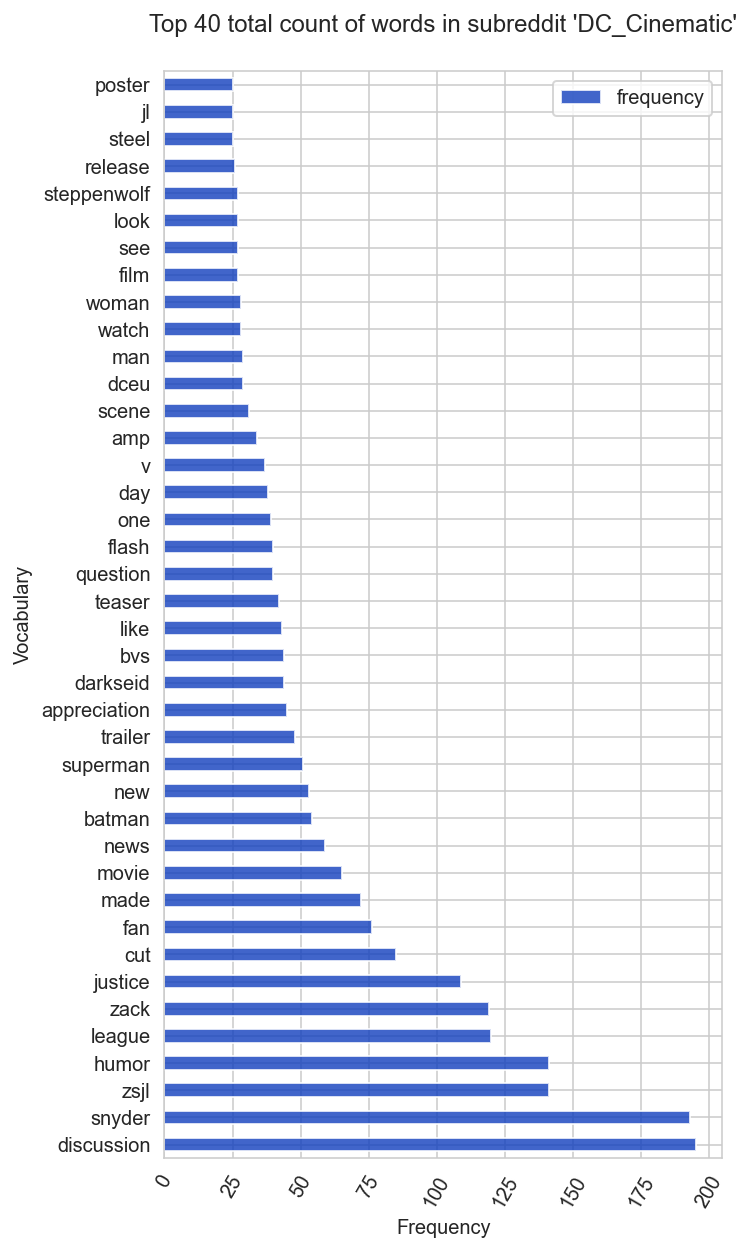

In [273]:
### Plot graph to analyze total number of words (Top40)

df_vocab_dc.head(40).plot(kind='barh',figsize=(5,10),color='#113FBD',alpha=0.8);
plt.legend();
plt.title("Top 40 total count of words in subreddit 'DC_Cinematic'\n",fontsize=12);
plt.xlabel('Frequency')
plt.ylabel('Vocabulary')
plt.xticks(rotation = 60);

## Word Cloud

In [50]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [51]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

## Subreddit : marvelstudios (word cloud)

In [52]:
### Filter only text of subreddit == 'marvelstudios'

text_m = df[df['subreddit']=='marvelstudios']['title_regex_onestring'].map(lambda x : x)
text_m.reset_index(drop=True,inplace=True)

In [172]:
text_m

0         assembled making wandavision discussion thread
1             falcon winter soldier final trailer disney
2                                         god bless mess
3          met noobmaster captain america winter soldier
4      peanut butter natasha eats endgame expires may...
                             ...                        
916                   killmonger plan avenger intervened
917    falcon winter soldier thunderbolt ross maria h...
918                                        glad got wish
919              wandavision episode original soundtrack
920              tony stark nickname reference explained
Name: title_regex_onestring, Length: 921, dtype: object

In [53]:
### Combine all posts to one list

text_ma = []
for i in range(len(text_m)):
    text_ma.append(text_m[i])

In [173]:
text_ma

['assembled making wandavision discussion thread',
 'falcon winter soldier final trailer disney',
 'god bless mess',
 'met noobmaster captain america winter soldier',
 'peanut butter natasha eats endgame expires may endgame meaning helping year old peanut butter thing even sadder imagined natasha post snap world',
 'three year since epic poster released avenger infinity war',
 'love helmet hud shot',
 'made stormbreaker hope guy enjoy',
 'captain america first avenger visual reference incredible hulk make sense considering hulk born trying recreate super soldier serum',
 'like photoshop old painting scott lang',
 'realized tony death endgame mirror yinsen death iron man position sharing one last meaningful exchange someone important',
 'celebration falcon amp winter soldier week never forget time sam wilson dropkicked helicopter',
 'made portrait tony stark hope guy like art',
 'looking back age ultron wandavision vision great philosophical thought provoking emotional line',
 'discussi

In [54]:
### Combine all posts to one string

text_marvel = " ".join(text_ma)
text_marvel

'assembled making wandavision discussion thread falcon winter soldier final trailer disney god bless mess met noobmaster captain america winter soldier peanut butter natasha eats endgame expires may endgame meaning helping year old peanut butter thing even sadder imagined natasha post snap world three year since epic poster released avenger infinity war love helmet hud shot made stormbreaker hope guy enjoy captain america first avenger visual reference incredible hulk make sense considering hulk born trying recreate super soldier serum like photoshop old painting scott lang realized tony death endgame mirror yinsen death iron man position sharing one last meaningful exchange someone important celebration falcon amp winter soldier week never forget time sam wilson dropkicked helicopter made portrait tony stark hope guy like art looking back age ultron wandavision vision great philosophical thought provoking emotional line discussion really excited see ben mendelsohn talos future mcu fun

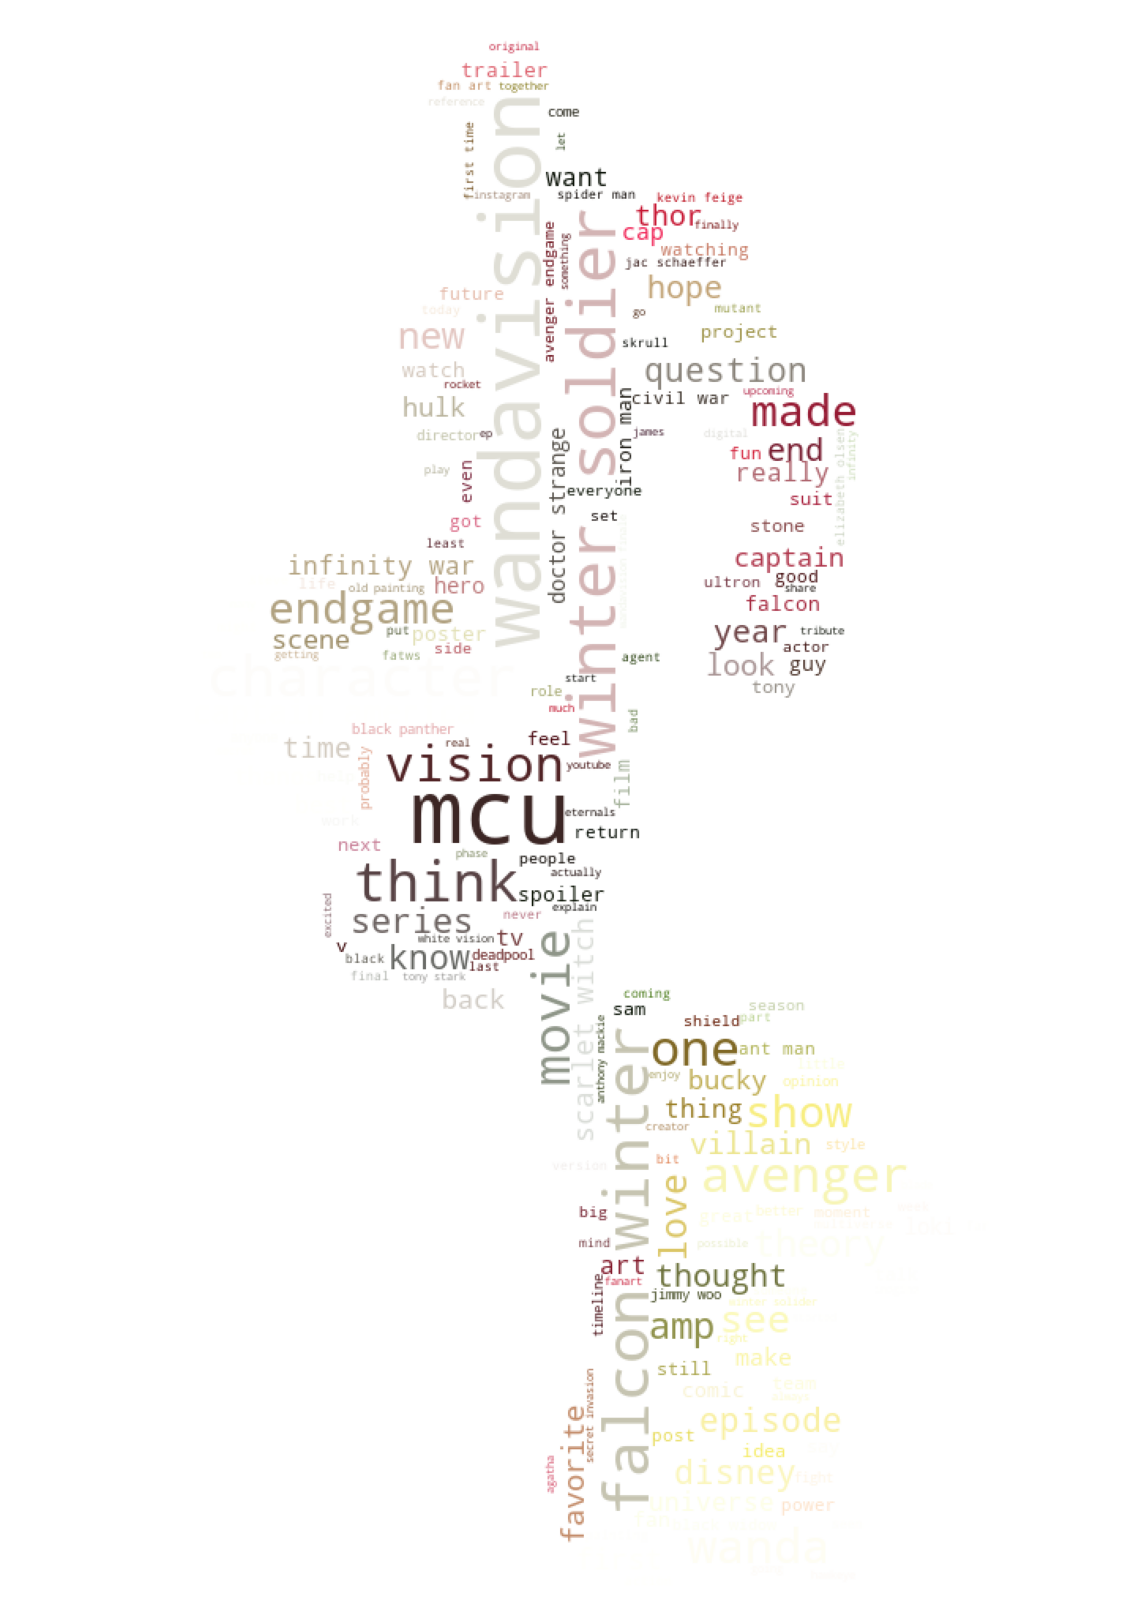

In [55]:
### Create wordcloud for 'marvel'

custom_mask = np.array(Image.open("ironman3.jpg"))
wc = WordCloud(background_color="white", mask=custom_mask)
wc.generate(text_marvel)
image_colors = ImageColorGenerator(custom_mask)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(10,15))
plt.imshow(wc)#, interpolation='bilinear')
plt.axis("off")
plt.show()

## Subreddit : DC_Cinematic (word cloud)

In [56]:
### Filter only text of subreddit == 'DC_Cinematic'

text_d = df[df['subreddit']=='DC_Cinematic']['title_regex_onestring'].map(lambda x : x)
text_d.reset_index(drop=True,inplace=True)

In [57]:
### Combine all posts to one list

text_dc = []
for j in range(len(text_d)):
    text_dc.append(text_d[j])

In [58]:
### Combine all posts to one string

text_dccinematic = " ".join(text_dc)
text_dccinematic

'r exclusive interview fan q amp director zack snyder zack snyder justice league review megathread post embargo edition review score related discussion belong humour elseworld lex luthor jeremy kirby approves zsjl humor u clock strike midnight moment waited year appreciation remembering jon schnepp one first earliest people defend existence snyder cut rest peace make see zack true vision forautumn saw zsjl imax still going strong baby deborah snyder cameo bvs batfleck without cape fanart zsjl knightmare team godot art fanart joker playing poker ign poll humor help appreciation art make difference proof zsjl movement remembered good reason second mar leto band selling live society shirt half proceeds going afsp last night imax humor ready zack snyder wrote alexander great script franchise warner bros pandemic suggesting bridge burned discussion rewatching mo preparation snyder cut man professor hamilton awesome character fan made spent several day drawing piece hopefully like vicbazaine

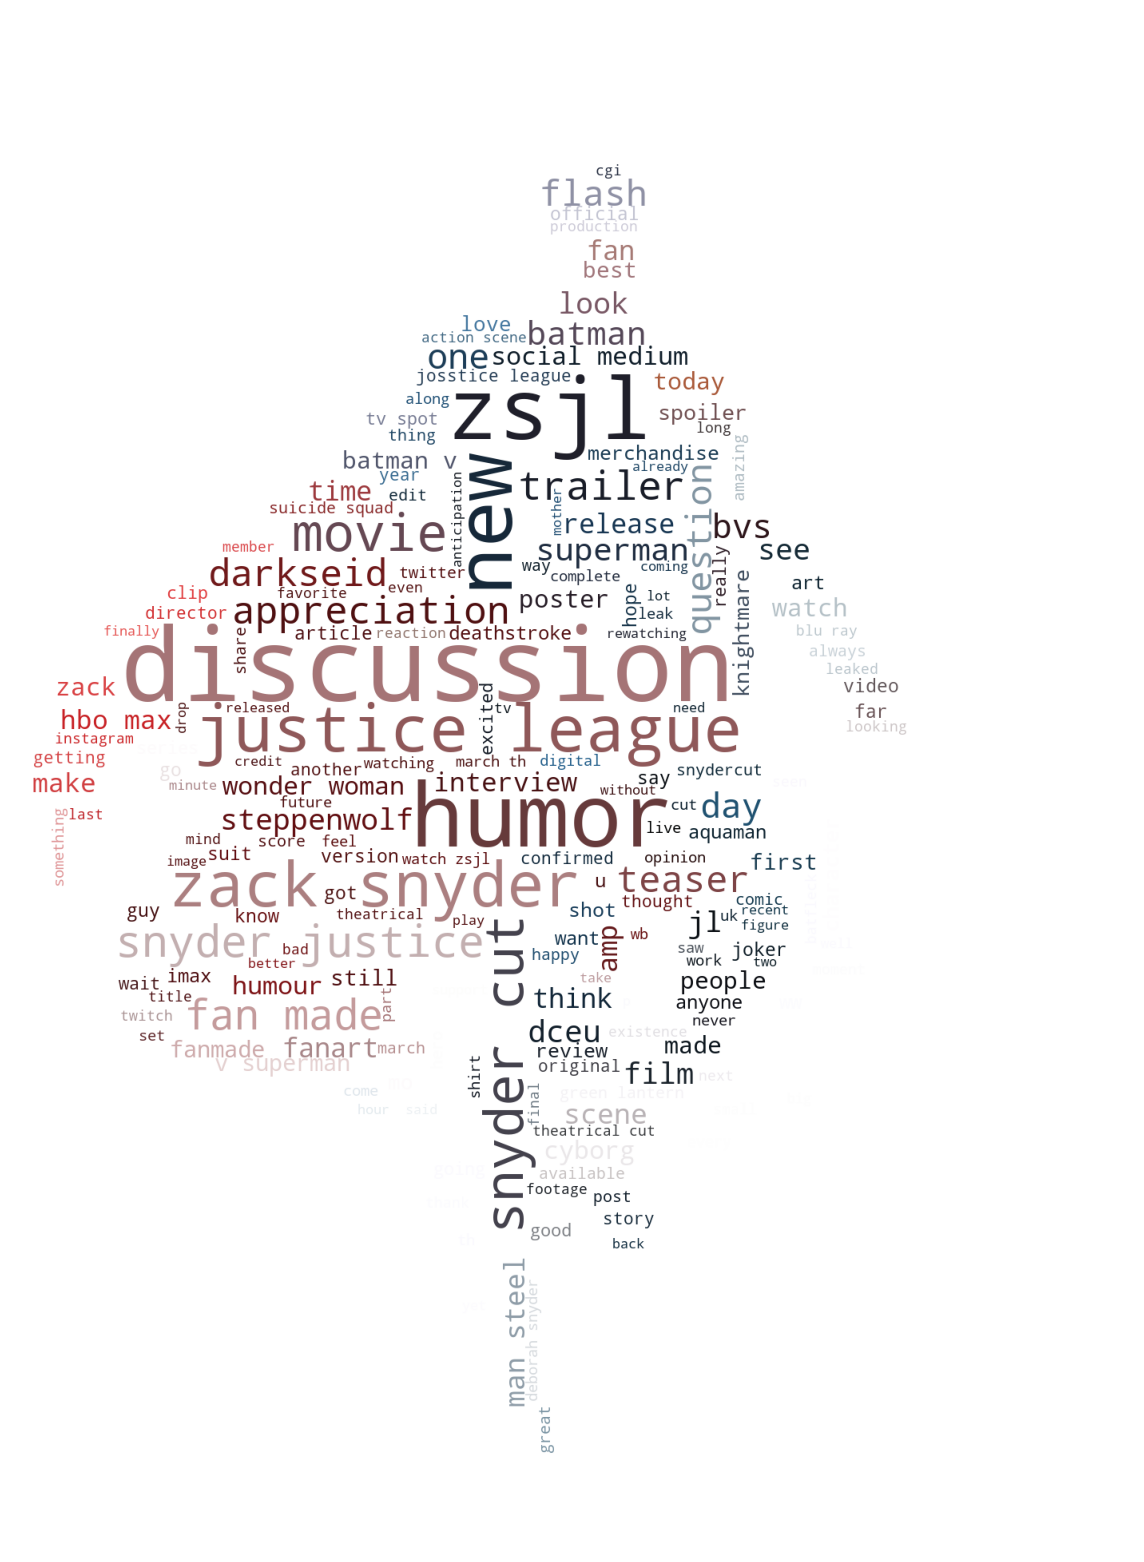

In [61]:
### Create wordcloud for 'DC'

custom_mask = np.array(Image.open("superman.jpg"))
wc = WordCloud(background_color="white", mask=custom_mask)
wc.generate(text_dccinematic)
image_colors = ImageColorGenerator(custom_mask)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(10,15))
plt.imshow(wc)#, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model
_____________________________________________________________________________________________________

1. CountVectorizer + MultinomialNB
2. CountVectorizer + Logistic Regression
3. TF-IDF Vectorizer + MultinomialNB
4. TF-IDF Vectorizer + Logistic Regression

## Train Test Split

In [62]:
df[['title_regex_onestring','subreddit']].head()

,title_regex_onestring,subreddit
0,assembled making wandavision discussion thread,marvelstudios
1,falcon winter soldier final trailer disney,marvelstudios
2,god bless mess,marvelstudios
3,met noobmaster captain america winter soldier,marvelstudios
4,peanut butter natasha eats endgame expires may...,marvelstudios


In [63]:
### Assign X = title and y = subreddit for train test split later

X = df['title_regex_onestring']
y = df['subreddit']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=101,stratify=y)

## CountVectorizer

In [66]:
### Create function to check number of suitable 'max_features'
### Use CountVectorizer for testing

def check_max_feature(train,test):
    
    lemmatizer = WordNetLemmatizer()
    test_lemma = []
    for i in range(100,5000,500):
        cvec = CountVectorizer(analyzer = "word",max_features = i)
        X_train_cvec = cvec.fit_transform(train)
        X_test_cvec = cvec.transform(test)
        vocab = cvec.get_feature_names()
        print(f'Lenght of Vocab = {len(vocab)}')

        for j in vocab:
            test_lemma.append(lemmatizer.lemmatize(j))
    
        print(f'Recommend max_features is {len(set(test_lemma))}')
        print('----------------------------------------------')
    
    return f'RECOMMEND NUMBER OF MAX FEATURES IS >>>> {len(set(test_lemma))}'

In [67]:
### Test function. The return value is the suitable 'max_features' for CountVectorizer

check_max_feature(X_train, X_test)

Lenght of Vocab = 100
Recommend max_features is 100
----------------------------------------------
Lenght of Vocab = 600
Recommend max_features is 600
----------------------------------------------
Lenght of Vocab = 1100
Recommend max_features is 1100
----------------------------------------------
Lenght of Vocab = 1600
Recommend max_features is 1600
----------------------------------------------
Lenght of Vocab = 2100
Recommend max_features is 2100
----------------------------------------------
Lenght of Vocab = 2600
Recommend max_features is 2600
----------------------------------------------
Lenght of Vocab = 2902
Recommend max_features is 2902
----------------------------------------------
Lenght of Vocab = 2902
Recommend max_features is 2902
----------------------------------------------
Lenght of Vocab = 2902
Recommend max_features is 2902
----------------------------------------------
Lenght of Vocab = 2902
Recommend max_features is 2902
-----------------------------------------

'RECOMMEND NUMBER OF MAX FEATURES IS >>>> 2902'

In [68]:
### Bring the data to CountVectorizer

cvec = CountVectorizer(analyzer = "word",max_features = 3000)
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [69]:
### List of vocab from text in X_train_cvec

vocab = cvec.get_feature_names()
print(f'Lenght of vocab = {len(vocab)}')
print('-------------------------------------------------------------------------------------------')
print(vocab[:100])

Lenght of vocab = 2902
-------------------------------------------------------------------------------------------
['aaron', 'able', 'abomination', 'absence', 'absolute', 'accent', 'accepting', 'accidentally', 'accolade', 'accord', 'according', 'account', 'accurate', 'acknowledged', 'across', 'acrylic', 'act', 'action', 'actor', 'actress', 'actual', 'actually', 'ad', 'adam', 'adaptation', 'adapted', 'adaption', 'add', 'added', 'addiction', 'addition', 'additional', 'address', 'adi', 'adir', 'adjusted', 'advisor', 'aether', 'affect', 'affleck', 'afsp', 'agamotto', 'agatha', 'age', 'aged', 'agent', 'aging', 'agnes', 'ago', 'agree', 'agreed', 'ah', 'aint', 'air', 'airplane', 'aka', 'al', 'alan', 'alexander', 'alfred', 'alive', 'allen', 'allow', 'allowed', 'alluding', 'ally', 'almost', 'alone', 'along', 'alongside', 'alot', 'already', 'alright', 'also', 'alternate', 'alternative', 'always', 'amazing', 'amazon', 'amc', 'amen', 'america', 'american', 'among', 'amount', 'amp', 'ampdt', 'ampli

In [70]:
### Change the vocab to DataFrame

train_df = pd.DataFrame(X_train_cvec.toarray(),columns=vocab)
train_df.head()

,aaron,able,abomination,absence,absolute,accent,accepting,accidentally,accolade,accord,...,zhao,zimmer,zinger,zis,zod,zoe,zoom,zoomed,zor,zsjl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Predict (Naive Bayes method) >> CountVectorizer

In [71]:
### Using MultinomialNB to predict

nb = MultinomialNB()

model_nb = nb.fit(X_train_cvec, y_train)

In [72]:
prediction_cvec_nb = model_nb.predict(X_test_cvec)
prediction_cvec_nb

array(['marvelstudios', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'marvelstud

In [73]:
### Score of train set

nb.score(X_train_cvec, y_train)

0.9857549857549858

In [74]:
### Score of test set

nb.score(X_test_cvec, y_test)

0.9316239316239316

In [75]:
### Accuracy Score

accuracy_score(y_test, prediction_cvec_nb)

0.9316239316239316

### Predict (Logistic Regression) >> CountVectorizer

In [76]:
lr = LogisticRegression()

In [77]:
### Fit the model to Logistic Regression

model_lr = lr.fit(X_train_cvec, y_train)

In [78]:
prediction_cvec_lr = model_lr.predict(X_test_cvec)
prediction_cvec_lr

array(['marvelstudios', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'DC_Cinematic',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'marvels

In [79]:
### Score of train set

lr.score(X_train_cvec, y_train)

0.9893162393162394

In [80]:
### Score of test set

lr.score(X_test_cvec, y_test)

0.9401709401709402

In [81]:
### Accuracy Score

accuracy_score(y_test, prediction_cvec_lr)

0.9401709401709402

## TF-IDF

In [82]:
### Bring the data to TF-IDF

tf = TfidfVectorizer(analyzer = "word",max_features = 3100)
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

In [83]:
### List of vocab from text in X_train_tf

vocab_tf = tf.get_feature_names()
print(f'Lenght of vocab = {len(vocab_tf)}')
print('-------------------------------------------------------------------------------------------')
print(vocab[:100])

Lenght of vocab = 2902
-------------------------------------------------------------------------------------------
['aaron', 'able', 'abomination', 'absence', 'absolute', 'accent', 'accepting', 'accidentally', 'accolade', 'accord', 'according', 'account', 'accurate', 'acknowledged', 'across', 'acrylic', 'act', 'action', 'actor', 'actress', 'actual', 'actually', 'ad', 'adam', 'adaptation', 'adapted', 'adaption', 'add', 'added', 'addiction', 'addition', 'additional', 'address', 'adi', 'adir', 'adjusted', 'advisor', 'aether', 'affect', 'affleck', 'afsp', 'agamotto', 'agatha', 'age', 'aged', 'agent', 'aging', 'agnes', 'ago', 'agree', 'agreed', 'ah', 'aint', 'air', 'airplane', 'aka', 'al', 'alan', 'alexander', 'alfred', 'alive', 'allen', 'allow', 'allowed', 'alluding', 'ally', 'almost', 'alone', 'along', 'alongside', 'alot', 'already', 'alright', 'also', 'alternate', 'alternative', 'always', 'amazing', 'amazon', 'amc', 'amen', 'america', 'american', 'among', 'amount', 'amp', 'ampdt', 'ampli

In [84]:
### Change the vocab to DataFrame

train_df_tf = pd.DataFrame(X_train_tf.toarray(),columns=vocab)
train_df_tf.head()

,aaron,able,abomination,absence,absolute,accent,accepting,accidentally,accolade,accord,...,zhao,zimmer,zinger,zis,zod,zoe,zoom,zoomed,zor,zsjl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264685
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Predict (Naive Bayes method) >> TF-IDF

In [85]:
### Using MultinomialNB to predict

nb = MultinomialNB()

model_nb_tf = nb.fit(X_train_tf, y_train)

In [86]:
prediction_tf_nb = model_nb_tf.predict(X_test_tf)
prediction_tf_nb

array(['marvelstudios', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'marvelstud

In [87]:
### Score of train set

nb.score(X_train_tf, y_train)

0.9878917378917379

In [88]:
### Score of test set

nb.score(X_test_tf, y_test)

0.9273504273504274

In [89]:
### Accuracy Score

accuracy_score(y_test, prediction_tf_nb)

0.9273504273504274

### Predict (Logistic Regression) >> TF-IDF

In [423]:
lr = LogisticRegression()

In [91]:
### Fit the model to Logistic Regression

model_lr_tf = lr.fit(X_train_tf, y_train)

In [92]:
prediction_tf_lr = model_lr_tf.predict(X_test_tf)
prediction_tf_lr

array(['marvelstudios', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'DC_Cinematic',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'marvelstudios',
       'marvelstudios', 'DC_Cinematic', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'marvelstudios',
       'marvelstudios', 'marvelstudios', 'marvelstudios', 'DC_Cinematic',
       'marvelstudios', 'DC_Cinematic', 'marvelstudios', 'marvelstudios',
       'DC_Cinematic', 'marvelstudios', 'DC_Cinematic', 'DC_Cinematic',
       'DC_Cinematic', 'marvelstudios', 'marvels

In [93]:
### Score of train set

lr.score(X_train_tf, y_train)

0.9857549857549858

In [94]:
### Score of test set

lr.score(X_test_tf, y_test)

0.9487179487179487

In [95]:
### Accuracy Score

accuracy_score(y_test, prediction_tf_lr)

0.9487179487179487

### Use Classification Report to evaluate score and accuracy of model >> TF-IDF & Logistic Regression

In [476]:
print(classification_report(y_test, prediction_tf_lr))

               precision    recall  f1-score   support

 DC_Cinematic       0.97      0.92      0.95       238
marvelstudios       0.93      0.97      0.95       230

     accuracy                           0.95       468
    macro avg       0.95      0.95      0.95       468
 weighted avg       0.95      0.95      0.95       468



### Confusion Matrix

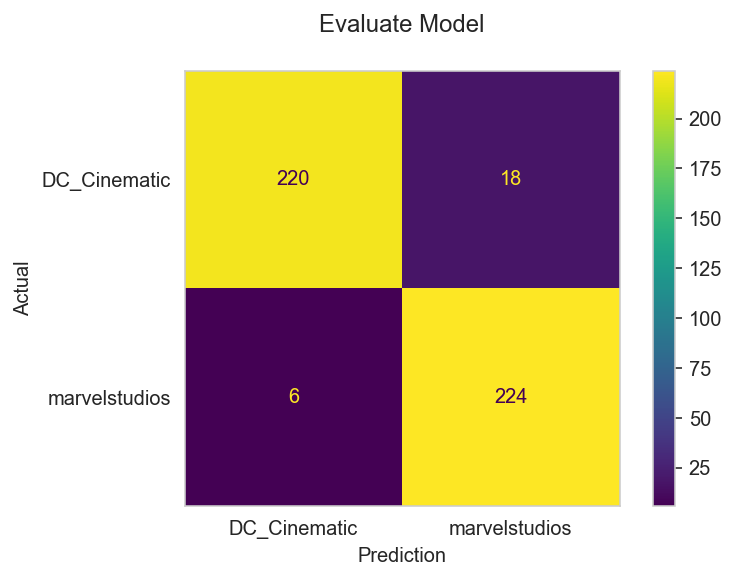

In [490]:
disp = plot_confusion_matrix(model_lr_tf, X_test_tf, y_test,cmap = plt.cm.viridis)
plt.grid()
plt.title('Evaluate Model\n')
plt.xlabel('Prediction')
plt.ylabel('Actual')
print(disp)

In [484]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction_tf_lr).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 220
False Positives: 18
False Negatives: 6
True Positives: 224


## GridSearchCV

In [104]:
# Let's set 4 pipeline up with two stages:

# Pipeline 1
# 1. CountVectorizer (transformer)
# 2. MultinomialNB (estimator)

pipe_1 = Pipeline([
    ('cvec',CountVectorizer()),
    ('nb',MultinomialNB())
])

# Pipeline 2
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_2 = Pipeline([
    ('cvec',CountVectorizer()),
    ('lr',LogisticRegression())
])

# Pipeline 3
# 1. TfidfVectorizer (transformer)
# 2. MultinomialNB (estimator)

pipe_3 = Pipeline([
    ('tf',TfidfVectorizer()),
    ('nb',MultinomialNB())
])

# Pipeline 4
# 1. TfidfVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_4 = Pipeline([
    ('tf',TfidfVectorizer()),
    ('lr',LogisticRegression())
])

### Pipeline 1 : CountVectorizer >> MultinomialNB

In [105]:
pipe_1.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [106]:
# Search over the following values of hyperparameters:

pipe_params_1 = {'cvec__max_features': [500,1000,1500,2000,2500,3000,3500],
              'cvec__min_df' : [2,3],
              'cvec__max_df' : [0.9,0.95],
              'cvec__ngram_range' : [(1,1),(1,2)]}

In [107]:
# Instantiate GridSearchCV.

gs_1 = GridSearchCV(pipe_1, # what object are we optimizing?
                  param_grid = pipe_params_1, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [108]:
# Fit GridSearch to training data.

gs_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 1500, 2000, 2500,
                                                3000, 3500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [499]:
# What's the best score?

gs_1.best_score_

0.9216471784443316

In [112]:
### GridSearch recommends the best parameter to get the best score

gs_1.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [111]:
# Save best model as gs_model.

gs_model_1 = gs_1.best_estimator_

In [500]:
# Score model on training set.

gs_model_1.score(X_train, y_train)

0.9615384615384616

In [113]:
# Score model on testing set.

gs_model_1.score(X_test, y_test)

0.9337606837606838

### Pipeline 2 : CountVectorizer >> Logistic Regression

In [114]:
pipe_2.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [115]:
# Search over the following values of hyperparameters:

pipe_params_2 = {'cvec__max_features': [500,1000,1500,2000,2500,3000,3500],
              'cvec__min_df' : [2,3],
              'cvec__max_df' : [0.9,0.95],
              'cvec__ngram_range' : [(1,1),(1,2)]}

In [116]:
# Instantiate GridSearchCV.

gs_2 = GridSearchCV(pipe_2, # what object are we optimizing?
                  param_grid = pipe_params_2, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [117]:
# Fit GridSearch to training data.
gs_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 1500, 2000, 2500,
                                                3000, 3500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [118]:
# What's the best score?
gs_2.best_score_

0.9330427046263345

In [121]:
### GridSearch recommends the best parameter to get the best score

gs_2.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [120]:
# Save best model as gs_model.

gs_model_2 = gs_2.best_estimator_

In [501]:
# Score model on training set.

gs_model_2.score(X_train, y_train)

0.9764957264957265

In [122]:
# Score model on testing set.

gs_model_2.score(X_test, y_test)

0.9401709401709402

### Pipeline 3 : TF-IDF Vectorizer >> MultinomialNB

In [123]:
pipe_3.get_params()

{'memory': None,
 'steps': [('tf', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tf': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tf__analyzer': 'word',
 'tf__binary': False,
 'tf__decode_error': 'strict',
 'tf__dtype': numpy.float64,
 'tf__encoding': 'utf-8',
 'tf__input': 'content',
 'tf__lowercase': True,
 'tf__max_df': 1.0,
 'tf__max_features': None,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 1),
 'tf__norm': 'l2',
 'tf__preprocessor': None,
 'tf__smooth_idf': True,
 'tf__stop_words': None,
 'tf__strip_accents': None,
 'tf__sublinear_tf': False,
 'tf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tf__tokenizer': None,
 'tf__use_idf': True,
 'tf__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [124]:
# Search over the following values of hyperparameters:

pipe_params_3 = {'tf__max_features': [500,1000,1500,2000,2500,3000,3500],
              'tf__min_df' : [2,3],
              'tf__max_df' : [0.9,0.95],
              'tf__ngram_range' : [(1,1),(1,2)]}

In [125]:
# Instantiate GridSearchCV.

gs_3 = GridSearchCV(pipe_3, # what object are we optimizing?
                  param_grid = pipe_params_3, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [126]:
# Fit GridSearch to training data.
gs_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_df': [0.9, 0.95],
                         'tf__max_features': [500, 1000, 1500, 2000, 2500, 3000,
                                              3500],
                         'tf__min_df': [2, 3],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [127]:
# What's the best score?
gs_3.best_score_

0.9159532282663957

In [130]:
### GridSearch recommends the best parameter to get the best score

gs_3.best_params_

{'tf__max_df': 0.9,
 'tf__max_features': 1000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 1)}

In [129]:
# Save best model as gs_model.

gs_model_3 = gs_3.best_estimator_

In [502]:
# Score model on training set.

gs_model_3.score(X_train, y_train)

0.9629629629629629

In [131]:
# Score model on testing set.

gs_model_3.score(X_test, y_test)

0.9316239316239316

### Pipeline 3 : TF-IDF Vectorizer >> Logistic Regression

In [132]:
pipe_4.get_params()

{'memory': None,
 'steps': [('tf', TfidfVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'tf': TfidfVectorizer(),
 'lr': LogisticRegression(),
 'tf__analyzer': 'word',
 'tf__binary': False,
 'tf__decode_error': 'strict',
 'tf__dtype': numpy.float64,
 'tf__encoding': 'utf-8',
 'tf__input': 'content',
 'tf__lowercase': True,
 'tf__max_df': 1.0,
 'tf__max_features': None,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 1),
 'tf__norm': 'l2',
 'tf__preprocessor': None,
 'tf__smooth_idf': True,
 'tf__stop_words': None,
 'tf__strip_accents': None,
 'tf__sublinear_tf': False,
 'tf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tf__tokenizer': None,
 'tf__use_idf': True,
 'tf__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0

In [133]:
# Search over the following values of hyperparameters:

pipe_params_4 = {'tf__max_features': [500,1000,1500,2000,2500,3000,3500],
              'tf__min_df' : [2,3],
              'tf__max_df' : [0.9,0.95],
              'tf__ngram_range' : [(1,1),(1,2)]}

In [134]:
# Instantiate GridSearchCV.

gs_4 = GridSearchCV(pipe_4, # what object are we optimizing?
                  param_grid = pipe_params_4, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [135]:
# Fit GridSearch to training data.
gs_4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tf__max_df': [0.9, 0.95],
                         'tf__max_features': [500, 1000, 1500, 2000, 2500, 3000,
                                              3500],
                         'tf__min_df': [2, 3],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [136]:
# What's the best score?

gs_4.best_score_

0.9309023894255212

In [139]:
### GridSearch recommends the best parameter to get the best score

gs_4.best_params_

{'tf__max_df': 0.9,
 'tf__max_features': 1000,
 'tf__min_df': 3,
 'tf__ngram_range': (1, 2)}

In [138]:
# Save best model as gs_model.

gs_model_4 = gs_4.best_estimator_

In [137]:
# Score model on training set.

gs_model_4.score(X_train, y_train)

0.9736467236467237

In [140]:
# Score model on testing set.

gs_model_4.score(X_test, y_test)

0.9465811965811965

## Setup Function to evaluate score

In [410]:
def cal_score(X_train, X_test, score = False, params = False):

    # Let's set 4 pipeline up with two stages:

    # Pipeline 1
    # 1. CountVectorizer (transformer)
    # 2. MultinomialNB (estimator)

    pipe_1 = Pipeline([
        ('cvec',CountVectorizer()),
        ('nb',MultinomialNB())
    ])

    # Pipeline 2
    # 1. CountVectorizer (transformer)
    # 2. LogisticRegression (estimator)

    pipe_2 = Pipeline([
        ('cvec',CountVectorizer()),
        ('lr',LogisticRegression())
    ])

    # Pipeline 3
    # 1. TfidfVectorizer (transformer)
    # 2. MultinomialNB (estimator)

    pipe_3 = Pipeline([
        ('tf',TfidfVectorizer()),
        ('nb',MultinomialNB())
    ])

    # Pipeline 4
    # 1. TfidfVectorizer (transformer)
    # 2. LogisticRegression (estimator)

    pipe_4 = Pipeline([
        ('tf',TfidfVectorizer()),
        ('lr',LogisticRegression())
    ])
    
    # Search over the following values of hyperparameters:

    pipe_params_1 = {'cvec__max_features': [500,1000,1500,2000,2500,3000,3500],
                  'cvec__min_df' : [2,3],
                  'cvec__max_df' : [0.9,0.95],
                  'cvec__ngram_range' : [(1,1),(1,2)]}
    pipe_params_2 = {'cvec__max_features': [500,1000,1500,2000,2500,3000,3500],
                  'cvec__min_df' : [2,3],
                  'cvec__max_df' : [0.9,0.95],
                  'cvec__ngram_range' : [(1,1),(1,2)]}
    pipe_params_3 = {'tf__max_features': [500,1000,1500,2000,2500,3000,3500],
                  'tf__min_df' : [2,3],
                  'tf__max_df' : [0.9,0.95],
                  'tf__ngram_range' : [(1,1),(1,2)]}
    pipe_params_4 = {'tf__max_features': [500,1000,1500,2000,2500,3000,3500],
                  'tf__min_df' : [2,3],
                  'tf__max_df' : [0.9,0.95],
                  'tf__ngram_range' : [(1,1),(1,2)]}
    
    # Instantiate GridSearchCV.

    gs_1 = GridSearchCV(pipe_1,
                      param_grid = pipe_params_1,
                      cv=5) # 5-fold cross-validation.
    gs_2 = GridSearchCV(pipe_2,
                      param_grid = pipe_params_2,
                      cv=5) # 5-fold cross-validation.
    gs_3 = GridSearchCV(pipe_3,
                      param_grid = pipe_params_3,
                      cv=5) # 5-fold cross-validation.
    gs_4 = GridSearchCV(pipe_4,
                      param_grid = pipe_params_4,
                      cv=5) # 5-fold cross-validation.
    
    # Fit GridSearch to training data.
    gs_1.fit(X_train, y_train);
    gs_2.fit(X_train, y_train);
    gs_3.fit(X_train, y_train);
    gs_4.fit(X_train, y_train);
    
    # Save best model as gs_model.
    gs_model_1 = gs_1.best_estimator_
    gs_model_2 = gs_2.best_estimator_
    gs_model_3 = gs_3.best_estimator_
    gs_model_4 = gs_4.best_estimator_
    
    if score:
#         print('Best Score >>')
#         print(f'Model 1: CountVectorizer + MultinomialNB = {gs_1.best_score_}')
#         print(f'Model 2: CountVectorizer + Logistic Regression = {gs_2.best_score_}')
#         print(f'Model 3: TF-IDF Vectorizer + MultinomialNB = {gs_3.best_score_}')
#         print(f'Model 4: TF-IDF Vectorizer + Logistic Regression = {gs_4.best_score_}')
#         print('--------------------------------------------------------------------------------------')

        print('Best Estimator from Training set >>')
        print(f'Model 1: CountVectorizer + MultinomialNB = {gs_model_1.score(X_train, y_train)}')
        print(f'Model 2: CountVectorizer + Logistic Regression = {gs_model_2.score(X_train, y_train)}')
        print(f'Model 3: TF-IDF Vectorizer + MultinomialNB = {gs_model_3.score(X_train, y_train)}')
        print(f'Model 4: TF-IDF Vectorizer + Logistic Regression = {gs_model_4.score(X_train, y_train)}')
        print('--------------------------------------------------------------------------------------')

        print('Best Estimator from Testing set >>')
        print(f'Model 1: CountVectorizer + MultinomialNB = {gs_model_1.score(X_test, y_test)}')
        print(f'Model 2: CountVectorizer + Logistic Regression = {gs_model_2.score(X_test, y_test)}')
        print(f'Model 3: TF-IDF Vectorizer + MultinomialNB = {gs_model_3.score(X_test, y_test)}')
        print(f'Model 4: TF-IDF Vectorizer + Logistic Regression = {gs_model_4.score(X_test, y_test)}')
        print('--------------------------------------------------------------------------------------\n')
    
    ###################################################################
    
    ### This section for prediction a new text. ###
    
    ### Finding the max score of testing set for getting the parameter to predict.
    
    dict_score = {gs_model_1.score(X_test, y_test):'gs1',
                  gs_model_2.score(X_test, y_test):'gs2',
                  gs_model_3.score(X_test, y_test):'gs3',
                  gs_model_4.score(X_test, y_test):'gs4'}
    
    ### Which model has the best score.
    max_score = dict_score[max(dict_score)]

    if params:
#         print('Recommend Parameters >>')
#         print(f'Model 1: CountVectorizer + MultinomialNB\nRecommend parameters are: {gs_1.best_params_}\n')
#         print(f'Model 2: CountVectorizer + Logistic Regression\nRecommend parameters are: {gs_2.best_params_}\n')
#         print(f'Model 3: TF-IDF Vectorizer + MultinomialNB\nRecommend parameters are: {gs_3.best_params_}\n')
#         print(f'Model 4: TF-IDF Vectorizer + Logistic Regression\nRecommend parameters are: {gs_4.best_params_}')
#         print('--------------------------------------------------------------------------------------')

        if max_score == 'gs1':
            gs_feature = gs_1.best_params_['cvec__max_features']
            gs_min_df = gs_1.best_params_['cvec__min_df']
            gs_max_df = gs_1.best_params_['cvec__max_df']
            gs_ngram = gs_1.best_params_['cvec__ngram_range']
            return [gs_feature, gs_min_df, gs_max_df, gs_ngram, 'cvec', 'nb']
        elif max_score == 'gs2':
            gs_feature = gs_2.best_params_['cvec__max_features']
            gs_min_df = gs_2.best_params_['cvec__min_df']
            gs_max_df = gs_2.best_params_['cvec__max_df']
            gs_ngram = gs_2.best_params_['cvec__ngram_range']
            return [gs_feature, gs_min_df, gs_max_df, gs_ngram, 'cvec', 'lr']
        elif max_score == 'gs3':
            gs_feature = gs_3.best_params_['tf__max_features']
            gs_min_df = gs_3.best_params_['tf__min_df']
            gs_max_df = gs_3.best_params_['tf__max_df']
            gs_ngram = gs_3.best_params_['tf__ngram_range']
            return [gs_feature, gs_min_df, gs_max_df, gs_ngram, 'tf', 'nb']
        elif max_score == 'gs4':
            gs_feature = gs_4.best_params_['tf__max_features']
            gs_min_df = gs_4.best_params_['tf__min_df']
            gs_max_df = gs_4.best_params_['tf__max_df']
            gs_ngram = gs_4.best_params_['tf__ngram_range']
            return [gs_feature, gs_min_df, gs_max_df, gs_ngram, 'tf', 'lr']

### Test function for calculation score

In [411]:
cal_score(X_train, X_test,score=True,params=True)

Best Estimator from Training set >>
Model 1: CountVectorizer + MultinomialNB = 0.9615384615384616
Model 2: CountVectorizer + Logistic Regression = 0.9764957264957265
Model 3: TF-IDF Vectorizer + MultinomialNB = 0.9629629629629629
Model 4: TF-IDF Vectorizer + Logistic Regression = 0.9736467236467237
--------------------------------------------------------------------------------------
Best Estimator from Testing set >>
Model 1: CountVectorizer + MultinomialNB = 0.9337606837606838
Model 2: CountVectorizer + Logistic Regression = 0.9401709401709402
Model 3: TF-IDF Vectorizer + MultinomialNB = 0.9316239316239316
Model 4: TF-IDF Vectorizer + Logistic Regression = 0.9465811965811965
--------------------------------------------------------------------------------------



[1000, 3, 0.9, (1, 2), 'tf', 'lr']

## Setup Function to predict a new text

In [414]:
def predict_text(X_train,X_test):
    
    test_new_text = input('Please fill in your text >>')
    ### Regex
    test_new_text = re.sub("[^a-zA-Z]"," ", test_new_text)
    ### Split text to words
    test_new_text = test_new_text.split()
    ### Remove Stop words
    test_new_text = [w for w in test_new_text if w not in stopwords.words('english')]
    ### Lemmatizing
    test_new_text = [lemmatizer.lemmatize(w) for w in test_new_text]
    ### Join words to text
    test_new_text = " ".join(test_new_text)
    ### Change text to Series
    X_test_text = pd.Series([test_new_text])
    
    
    nb = MultinomialNB()
    lr = LogisticRegression()
    
    ### Use the function 'cal_score' to evatuate score
    best_param = cal_score(X_train, X_test, score=False, params=True)
    
    if best_param[4]=='cvec':
        cvec = CountVectorizer(analyzer = "word",
                               max_features = best_param[0],
                               min_df = best_param[1],
                               max_df = best_param[2],
                               ngram_range = best_param[3])
        
        ### Bring the data to CountVectorizer

        X_train_cvec = cvec.fit_transform(X_train)
        X_test_cvec = cvec.transform(X_test_text)
        
        if best_param[5]=='nb':

            ### Using MultinomialNB to predict

            model_nb = nb.fit(X_train_cvec, y_train)
            prediction_cvec_nb = model_nb.predict(X_test_cvec)
            print('Best Model is: CountVectorizer + MultinomialNB >>')
            print(f'Your text is {prediction_cvec_nb[0]} subreddit !!!')
            
        elif best_param[5]=='lr':

            ### Using Logistic Regression to predict

            model_lr = lr.fit(X_train_cvec, y_train)
            prediction_cvec_lr = model_lr.predict(X_test_cvec)
            print('Best Model is: CountVectorizer + Logistic Regression >>')
            print(f'Your text is {prediction_cvec_lr[0]} subreddit !!!')

    ###################################################################
        
                
    elif best_param[4]=='tf':
        tf = TfidfVectorizer(analyzer = "word",
                             max_features = best_param[0],
                             min_df = best_param[1],
                             max_df = best_param[2],
                             ngram_range = best_param[3])
    
        ### Bring the data to TF-IDF

        X_train_tf = tf.fit_transform(X_train)
        X_test_tf = tf.transform(X_test_text)
        
        if best_param[5]=='nb':

            ### Using MultinomialNB to predict

            model_nb_tf = nb.fit(X_train_tf, y_train)
            prediction_tf_nb = model_nb_tf.predict(X_test_tf)
            print('Best Model is: TF-IDF + MultinomialNB >>')
            print(f'Your text is {prediction_tf_nb[0]} subreddit !!!\n')
            
        elif best_param[5]=='lr':

            ### Using Logistic Regression to predict

            model_lr_tf = lr.fit(X_train_tf, y_train)
            prediction_tf_lr = model_lr_tf.predict(X_test_tf)
            print('Best Model is: TF-IDF + Logistic Regression >>')
            print(f'Your text is {prediction_tf_lr[0]} subreddit !!!')
        
    ###################################################################

### Test function for prediction

In [415]:
predict_text(X_train,X_test)

Please fill in your text >> What if the Iron Man movies had been a Disney+ Series?
Best Model is: TF-IDF + Logistic Regression >>
Your text is marvelstudios subreddit !!!


# Conclusion
_____________________________________________________________________________________________________

1. Top 5 popular words of “marvelstudios” are “mcu, wandavision, falcon, winter and soldier. Top 5 of “DC_Cinematic” are “discussion, snyder, zsji, humor and league.  
2. From EDA, I found the abnormal popular words of “DC_Cinematic”. So in the step of gathering the data, we need to check the form of source and try to understand it.
3. The model (TF-IDF) can predict with good accuracy to classify the subreddit. 
4. Can apply to use in real working to classify text from chat or Email.